In [1]:
import matplotlib.pyplot as plt
import numpy as np 
import networkx as nx
from tqdm import tqdm

from src.maincolors import get_main_colors, show_main_colors

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
def read_image(frame: str):
    frame = frame.zfill(6)
    return plt.imread("./data/VOCdevkit/VOC2007/JPEGImages/" + frame + ".jpg")

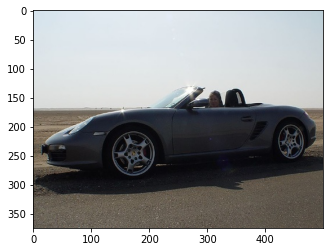

In [4]:
dummy_image = read_image("245")
plt.imshow(dummy_image)

# Histogram of colors

In [5]:
reshaped_image = dummy_image.reshape((-1, 3))
main_colors = get_main_colors(reshaped_image, 3, 5)

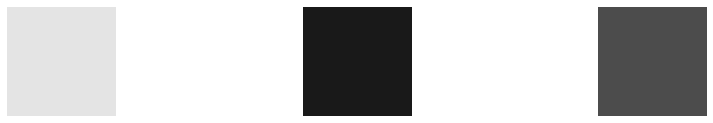

In [6]:
show_main_colors(main_colors)

In [7]:
def compute_masks(main_colors: np.ndarray, image: np.ndarray):
    masks = []
    for main_color in main_colors:
        condition = (image[..., 0] > main_color[0, 0]) & (image[..., 0] < main_color[0, 1])
        condition = condition & (image[..., 1] > main_color[1, 0]) & (image[..., 1] < main_color[1, 1])
        condition = condition & (image[..., 2] > main_color[2, 0]) & (image[..., 2] < main_color[2, 1])
        masks.append(condition)
    return masks

In [8]:
def compute_distributions(masks, image):
    distributions = []
    for mask in masks:
        sub_image = image[mask]
        distributions.append(
            dict(
                mu = np.mean(sub_image, axis=0),
                sigma2 = np.var(sub_image, axis=0)
            )
        )
    return distributions

In [9]:
def show_mask(mask, image):
    r = np.where(mask, image[..., 0], 255)[..., np.newaxis]
    g = np.where(mask, image[..., 1], 255)[..., np.newaxis]
    b = np.where(mask, image[..., 2], 255)[..., np.newaxis]
    plt.imshow(np.concatenate([r,g,b], axis=-1))

In [10]:
masks = compute_masks(main_colors, dummy_image)
distributions = compute_distributions(masks, dummy_image)

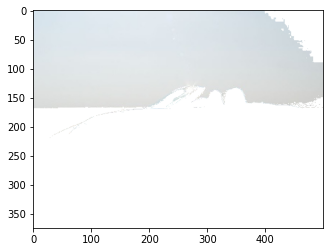

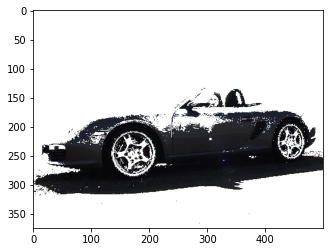

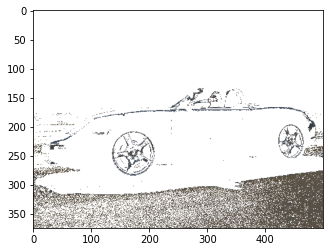

In [11]:
for mask in masks:
    show_mask(mask, dummy_image)
    plt.show()

In [12]:
distributions

[{'mu': array([220.23030189, 226.0637512 , 229.10044428]),
  'sigma2': array([36.02885805, 38.35759406, 63.66272435])},
 {'mu': array([21.93403369, 22.36752365, 27.2991567 ]),
  'sigma2': array([115.23156777, 126.16556038, 155.27809047])},
 {'mu': array([87.87857309, 81.47044697, 73.05953211]),
  'sigma2': array([122.73848968,  72.49182551,  77.53999145])}]

# Computing costs

In [13]:
def data_cost(pixel, distributions):
    conditional_probas = []
    for distribution in distributions:
        mu, sigma2 = distribution["mu"], distribution["sigma2"]
        proba = 1/np.sqrt(sigma2) * np.exp(-(pixel - mu) ** 2 / 2 / sigma2)
        conditional_probas.append(proba)
    conditional_probas = np.array(conditional_probas)
    probas = conditional_probas / np.sum(conditional_probas, axis=0)
    return - np.sum(np.log(probas), axis=1)

In [14]:
def smooth_cost(label_1, label_2, epsilon):
    if label_1 == label_2:
        return 0
    else:
        return epsilon

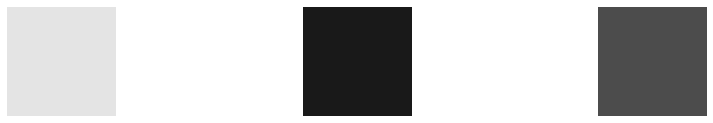

In [15]:
show_main_colors(main_colors)

In [16]:
data_cost((250, 250, 250), distributions)

array([ -0.        , 569.16912429, 482.68422116])

# Building graph

In [18]:
def build_base_graph(image):
    reshaped_image = image.reshape(-1, 3)
    
    graph = nx.Graph()
    mapping_pixels = dict()
        
    for n in tqdm(range(reshaped_image.shape[0])):
        mapping_pixels[str(n)] = reshaped_image[n]
    
    graph.add_nodes_from(mapping_pixels.keys())
    return graph

In [19]:
params = {
    "n_colors": 3,
    "bins": 5,
    "epsilon": 30,
    "lambda": 1/10
}

main_colors = get_main_colors(reshaped_image, params["n_colors"], params["bins"])
masks = compute_masks(main_colors, dummy_image)
distributions = compute_distributions(masks, dummy_image)


base_graph = build_base_graph(dummy_image)

100%|██████████| 187500/187500 [00:00<00:00, 2011520.24it/s]


In [44]:
def make_arbitrary_partition(image, main_colors):
    partition = {k:set() for k in range(len(main_colors))}
    reshaped_image = image.reshape(-1, 3)
    for n in range(len(reshaped_image)):
        pixel = reshaped_image[n]
        distances = np.linalg.norm(pixel - np.mean(main_colors, 2), axis=1)
        label = np.argmin(distances)
        partition[label].add(str(n))
        
    return partition

In [45]:
partition = make_arbitrary_partition(dummy_image, main_colors)

In [46]:
def construct_segmentation(partition, shape):
    new_image = np.zeros(shape)
    for label in partition:
        for node in partition[label]:
            if int(node) > -1:
                index = np.unravel_index(int(node), shape)
                new_image[index] = label
    return new_image

In [47]:
def show_segmentation(image, partition):
    shape = image.shape[:-1]
    segmented_image = construct_segmentation(partition, shape)
    fig, axes = plt.subplots(1, 2, figsize=(10, 10))
    axes[0].imshow(image)
    axes[0].set_axis_off()
    axes[1].imshow(segmented_image)
    axes[1].set_axis_off()

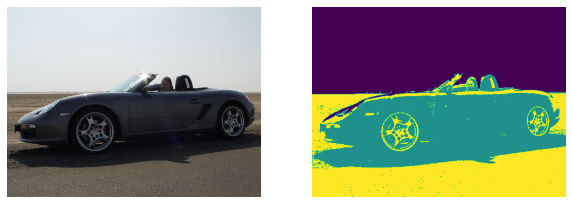

In [48]:
show_segmentation(dummy_image, partition)

In [25]:
def get_label(n: int, partition: dict):
    for label in partition:
        if str(n) in partition[label]:
            return label
    raise ValueError()

In [30]:
def get_neighboors(flattened_index, shape):
    x, y = np.unravel_index(flattened_index, shape)
    
    i_range = [1]
    j_range = [1]
    if x == shape[0] - 1:
        i_range.remove(1)
    if y == shape[1] - 1:
        j_range.remove(1)
        
    neighboors = []
    for i in i_range:
        for j in j_range:
            neighboors.append((x + i, y + j))
            
    return neighboors

In [32]:
def add_data_edges(base_graph: nx.Graph, distributions: dict, alpha: int, image: np.ndarray, partition: dict, params: dict):
    graph = base_graph.copy()
    reshaped_image = image.reshape(-1, 3)
    
    source = -1 # alpha
    target = -2 # non-alpha
    
    graph.add_nodes_from([str(source), str(target)])
    
    auxiliary_nodes = []
    edges = []
    for n in tqdm(range(reshaped_image.shape[0])):
        pixel = reshaped_image[n]
        data_costs = params["lambda"] * data_cost(pixel, distributions)
        edges.append(
            (str(n), str(source), dict(capacity = data_costs[alpha]))
        )
        
        label = get_label(n, partition)
        
        if label == "alpha":
            edges.append(
                (str(n), str(target), dict(capacity = np.inf))
            )
        else:
            label = get_label(n, partition)
            edges.append(
                (str(n), str(target), dict(capacity = data_costs[label]))
            )
            
        neighboors = get_neighboors(n, image.shape[:-1])
        
        for i, j in neighboors:
            flattened_index = np.ravel_multi_index((i, j), image.shape[:-1])
            label_neighboor = get_label(np.ravel_multi_index((i, j), image.shape[:-1]), partition)
            
            cost = smooth_cost(label, label_neighboor, params["epsilon"])
            if label_neighboor != label:
                auxiliary_node = f"auxiliary_{i}_{j}"
                auxiliary_nodes.append(auxiliary_node)
                cost_n = smooth_cost(label, alpha, params["epsilon"])
                edges.append(
                    (str(n), auxiliary_node, dict(capacity=cost_n))
                )
                cost_neighboor = smooth_cost(label_neighboor, alpha, params["epsilon"])
                edges.append(
                    (auxiliary_node, str(flattened_index), dict(capacity=cost_neighboor))
                )
                edges.append(
                    (auxiliary_node, target, dict(capacity=cost))
                )
            
    graph.add_nodes_from(auxiliary_nodes)
    graph.add_edges_from(edges)
    return graph, set(auxiliary_nodes)

In [52]:
def make_expansion(original_partition, binary_partition, alpha, auxiliary_nodes):
    binary_partition = [partition.difference({"-1", "-2"}.union(auxiliary_nodes)) for partition in binary_partition]
    final_partition = dict()
    for label in original_partition:
        if label != alpha:
            final_partition[label] = original_partition[label].intersection(binary_partition[1])
        else:
            final_partition[label] = original_partition[label].union(binary_partition[0])
    return final_partition, binary_partition

In [34]:
def compute_energy(partition: dict, distributions):
    energy = 0 
    for n in tqdm(range(reshaped_image.shape[0])):
        pixel = reshaped_image[n]
        data_costs = data_cost(pixel, distributions)
        label = get_label(n, partition)
        energy += data_costs[label]
        # neighboors = get_neighboors(n, image.shape[:-1])
        # for i, j in neighboors:
        #     label_pixel = get_label(n, partition)
        #     label_neighboor = get_label(np.ravel_multi_index((i, j), image.shape[:-1]), partition)
        #     cost = smooth_cost(label_pixel, label_neighboor, params["epsilon"])
        #     energy += cost
    return energy

In [36]:
partitions = [partition]
for k in range(10):
    original_parition = partition
    partitions = []
    energies = []
    for alpha in range(params["n_colors"]):
        print("Alpha:", alpha)
        new_graph, auxiliary_nodes = add_data_edges(base_graph, distributions, alpha, dummy_image, original_parition, params)
        cut_value, binary_partition = nx.algorithms.minimum_cut(new_graph, "-1", "-2")
        new_partition = make_expansion(original_parition, binary_partition, alpha, auxiliary_nodes)
        partitions.append(new_partition)
        energies.append(compute_energy(new_partition, ))

Alpha: 0


100%|██████████| 187500/187500 [08:40<00:00, 360.07it/s]


NameError: name 'new_partition' is not defined

In [53]:
original_parition = partition
new_partition, o = make_expansion(original_parition, binary_partition, alpha, auxiliary_nodes)

In [55]:
binary_partition

({'112308',
  '65778',
  '183829',
  '13067',
  '154785',
  '3435',
  '1817',
  '110660',
  '18007',
  '123399',
  '115336',
  '115544',
  '175651',
  '96976',
  '134655',
  '112217',
  '90980',
  '97411',
  '31054',
  '37077',
  '63762',
  '132930',
  '142456',
  '104369',
  '74755',
  '183264',
  '20105',
  '25466',
  '136981',
  '28375',
  '66033',
  '8045',
  '183052',
  '132439',
  'auxiliary_198_265',
  '53562',
  '145434',
  'auxiliary_174_296',
  '127255',
  '186810',
  '91256',
  '5332',
  '46844',
  '161473',
  '102637',
  '11948',
  '102467',
  '67066',
  '23824',
  '40841',
  '52373',
  '157684',
  '19052',
  '41106',
  '104180',
  '124361',
  '17088',
  '161907',
  '10760',
  '55323',
  '65294',
  '150755',
  '168833',
  '78151',
  '181327',
  '68009',
  '161325',
  '170347',
  '1319',
  '66116',
  '122286',
  '116598',
  '85007',
  '75660',
  '165097',
  '155541',
  '31250',
  '2092',
  '155297',
  '171349',
  '44622',
  '163584',
  '41771',
  '172667',
  '23235',
  '7712

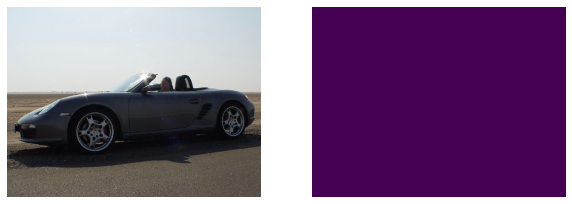

In [51]:
show_segmentation(dummy_image, new_partition)

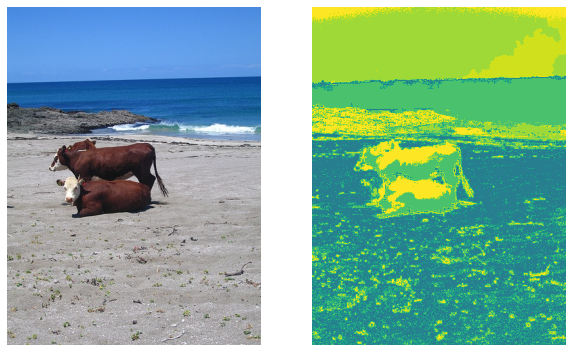

In [88]:
show_segmentation(dummy_image, new_partition)

In [233]:
energy = compute_energy(partition, dummy_image)

100%|██████████| 187500/187500 [00:08<00:00, 22854.18it/s]


In [234]:
energy

42780831.69236101

In [235]:
new_energy = compute_energy(new_partition, dummy_image)

100%|██████████| 187500/187500 [00:07<00:00, 24345.69it/s]


In [236]:
new_energy

67410598.1973292

In [237]:
new_energy < energy

False

In [90]:
energies = []
for partition in partitions:
    energies.append(compute_energy(partition, dummy_image))

100%|██████████| 187500/187500 [00:08<00:00, 21785.45it/s]


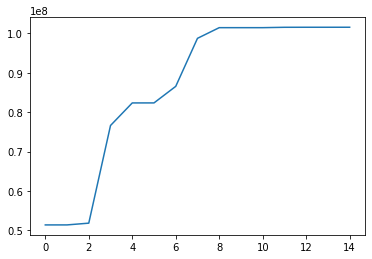

In [91]:
plt.plot(energies)

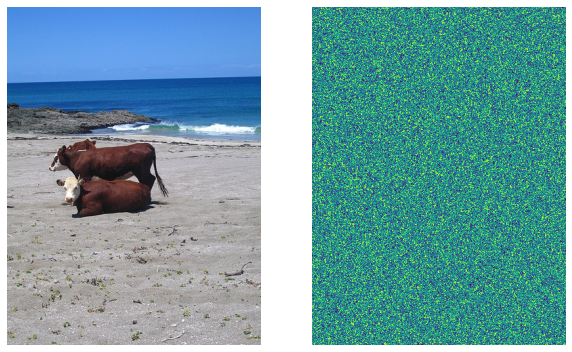

In [92]:
show_segmentation(dummy_image, partitions[0])

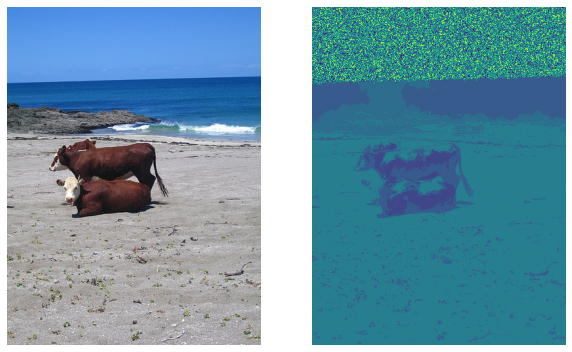

In [95]:
show_segmentation(dummy_image, partitions[5])

In [111]:
def compute_energy(partitions, image):
    reshaped_image = image.reshape(-1, 3)
    unflatten_indexes, edges = get_best_colors(reshaped_image, n_colors=params["n_colors"], bins=params["bins"])
    main_colors = get_main_colors(unflatten_indexes, np.array(edges))
    distributions = get_distributions(main_colors, image)
    
    energies = [0] * len(partitions)
    for n in tqdm(range(reshaped_image.shape[0])):
        pixel = reshaped_image[n]
        data_costs = data_cost(pixel, distributions)
        neighboors = get_neighboors(n, image.shape[:-1])
        for index, partition in enumerate(partitions):
            label = get_label(n, partition)
            energies[index] += data_costs[label]
            for i, j in neighboors:
                label_neighboor = get_label(np.ravel_multi_index((i, j), image.shape[:-1]), partition)
                cost = smooth_cost(label, label_neighboor, params["epsilon"])
                energies[index] += cost
    return energies

In [112]:
energies = compute_energy(partitions, dummy_image)

100%|██████████| 187500/187500 [01:04<00:00, 2903.08it/s]


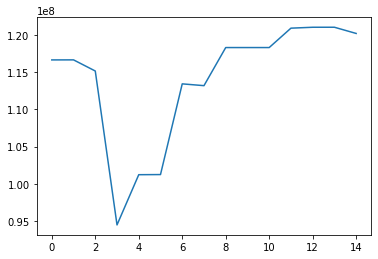

In [115]:
plt.plot(energies)